# day22: Principal Components Analysis


# Objectives

* Understand PCA on both toy and "real" image datasets
* Get familiar with how to perform transformations to low-dim. embeddings.
* Get familiar with how to "reconstruct" images

# Outline

* [Part 1: PCA for toy data with F=2 features](#part1)
* [Part 2: PCA with K=10 for image data with many features](#part2)
* [Part 3: PCA where we select K for image data with many features](#part3)

# Takeaways

* Understanding how we add/remove the *mean* vector is important
* Understanding that PCA is a nested model
* * The component vectors for K=4 are the first four components of K=5, K=6, or K=10 or ...)
* Selecting the number of components can be done in several ways:
* * Using the fraction of explained variance criteria, as discussed here
* * * Can be done very fast by reusing eigenvalues used at training time anyway
* * Use an application specific performance metric

In [1]:
import numpy as np
import pandas as pd

In [2]:
import sklearn.datasets

In [3]:
import sklearn.decomposition

In [4]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

In [5]:
import matplotlib.colors as mcolors

# Setup: Create Small Toy Dataset with F=2

We will have N=21 examples, with 2 features $x_1$ and $x_2$

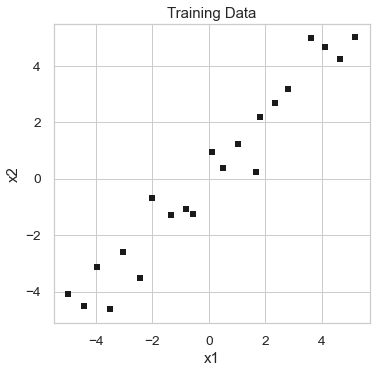

In [6]:
random_state = np.random.RandomState(0)

# Create N training x values between -5 and 5
N = 21
F = 2

x1_N = np.linspace(-5, 5, N) + random_state.uniform(low=-0.2, high=0.2, size=N)

B = 1.5
x2_N = 1.0 * x1_N + random_state.uniform(low=-B, high=B, size=N)

x_NF = np.zeros((N,F))
x_NF[:,0] = x1_N
x_NF[:,1] = x2_N

# Plot the training data
plt.plot(x1_N, x2_N, 'ks')
plt.title('Training Data')
plt.xlabel('x1');
plt.ylabel('x2');
plt.gca().set_aspect('equal', 'box')

# Review: Math of Principal Components Analysis (PCA)

We'll assume feature vectors  $x \in \mathbf{R}^F$.

We want to find a principal components analysis model with $K$ components, which has parameters:
* $m \in \mathbb{R}^F$ : mean vector
* $W \in \mathbb{R}^{F \times K}$ : weight vectorss for each component

This model makes projections to the latent "codes" $z_n \in \mathbb{R}^K$ like this:
$$
z_n = \mathbf{W}^T (\mathbf{x}_n - \mathbf{m})
$$

And then makes reconstructions like this:
$$
\hat{x}_n(\mathbf{m}, \mathbf{W}) = \mathbf{W} z_n + \mathbf{m}
$$

The training objective is:
$$
\min_{\mathbf{m} \in \mathbb{R}^F, \mathbf{W} \in \mathbb{R}^{F\times K}}
\quad \sum_{n=1}^N \sum_{f=1}^F (\mathbf{x}_{nf} - \hat{\mathbf{x}}_{nf}(\mathbf{m}, \mathbf{W}) )^2
$$


# Part 1: PCA for F=2 data

## Fit a pca model with K=1 component to our data

In [7]:
pca = sklearn.decomposition.PCA(n_components=1)

In [8]:
pca.fit(x_NF)

PCA(n_components=1)

This fitting process estimates two parameters, $m$ and $W$, and stores them as attributes of `pca`

## Inspecting the learned Mean vector $m$

This vector is accessible as the `mean_` attribute

In [9]:
m_F = pca.mean_
print(m_F.shape)
print("")
print(m_F)

(2,)

[0.04018504 0.13658959]


## Exercise 1a: Can you convince yourself that this is the same as the training set's empirical mean vector?

Compute the mean of each feature in the training set `x_NF`

In [10]:
# TODO

## Inspecting the learned weights $W$

This vector is accessible as the `components_` attribute of our learned `pca` model

In [11]:
w_KF = pca.components_
print(w_KF.shape)
print("")
print(w_KF)


(1, 2)

[[0.69601341 0.71802879]]


## Exercise 1b: Can you convince yourself that this weight vector is a unit vector?

That is, is the sum-of-squares magnitude of each component vector (each row) equal to one?

In [12]:
# TODO compute sum of squares of each row of w_KF

## Calling `transform`: Obtaining the low-dimensional embeddings

In [13]:
z_NK = pca.transform(x_NF)

In [14]:
print(z_NK.shape)
print("")
print(z_NK)

(21, 1)

[[-6.52423243]
 [-6.4504965 ]
 [-5.11980459]
 [-5.87207543]
 [-4.10995134]
 [-4.34687772]
 [-2.03157546]
 [-1.97845129]
 [-1.46165685]
 [-1.40616067]
 [ 0.62968306]
 [ 0.50286399]
 [ 1.47389739]
 [ 1.19917502]
 [ 2.71280757]
 [ 3.41699812]
 [ 4.09659534]
 [ 5.96711016]
 [ 6.07911096]
 [ 6.14379828]
 [ 7.07924238]]


### Compute the reconstructions

Each training example (index $n$) can be reconstructed as:

$$
\hat{x}_n(\mathbf{m}, \mathbf{W}) = \mathbf{W} z_n + \mathbf{m}
$$

If we convert this to matrix-vector arithmetic for the full dataset, we can do:

$$
\hat{X} = \mathbf{Z} \mathbf{W} + \mathbf{m}
$$

where $\hat{X}$ is an $N \times F$ matrix, where each row is equal to $\hat{x}_n(\mathbf{m}, \mathbf{W})$

In [15]:
xhat_NF = np.dot(z_NK, w_KF) + m_F[np.newaxis,:]

In [16]:
print(xhat_NF.shape)
print()
print("First 5 rows of this array")
print(xhat_NF[:5])

(21, 2)

First 5 rows of this array
[[-4.5007682  -4.54799709]
 [-4.449447   -4.49505257]
 [-3.52326759 -3.53957748]
 [-4.04685818 -4.07972959]
 [-2.82039619 -2.81447377]]


### Visualize the reconstructions

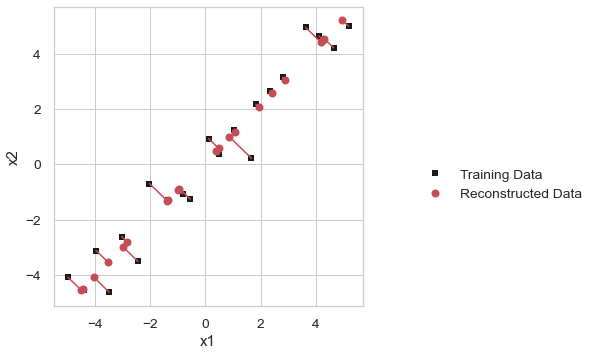

In [17]:
# Plot the training data
plt.plot(x1_N, x2_N, 'ks', label='Training Data')

# Plot the reconstructed data
plt.plot(xhat_NF[:,0], xhat_NF[:,1], 'r.', label='Reconstructed Data', mew=5)

# Draw line between training example and reconstruction
for n in range(N):
    xy_22 = np.zeros((2,2))
    xy_22[0] = x_NF[n,:]
    xy_22[1] = xhat_NF[n,:]
    plt.plot(xy_22[:,0], xy_22[:,1], 'r-')

plt.legend(bbox_to_anchor=(1.75, 0.5))
plt.xlabel('x1');
plt.ylabel('x2');
plt.gca().set_aspect('equal', 'box')

## Show that we know how to perform the PCA transform ourselves

In [18]:
def my_transform(x_NF, w_KF, m_F):
    ''' Perform transformation to get low-dim embeddings
    
    Args
    ----
    x_NF : 2D array, shape (N,F)
    w_KF : 2D array, shape (K,F)
    m_F : 1D array, shape (F,)
    
    Returns
    -------
    z_NK : 2D array, shape (n_examples, n_components) = (N,K)
        Each row is a low-dim. "embedding" of the corresponding row in x_NF
    '''
    
    # Use the equation defining z in terms of x and m and W
    z_NF = np.dot(x_NF - m_F[np.newaxis,:], w_KF.T)
    return z_NF

In [19]:
z_NK = my_transform(x_NF, w_KF, m_F)

In [20]:
print("Shape of z_NK")
print(z_NK.shape)
print()
print("First 5 rows of z_NK")
print(z_NK[:5])

Shape of z_NK
(21, 1)

First 5 rows of z_NK
[[-6.52423243]
 [-6.4504965 ]
 [-5.11980459]
 [-5.87207543]
 [-4.10995134]]


## Discussion 1c: Are these z_NK values from `my_transform` the same as produced by `pca.transform`? 


In [21]:
# TODO discuss

## Now try with K=2 PCA for our F=2 dataset

In [22]:
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(x_NF)

PCA(n_components=2)

Print out the transformed embedding features:

In [23]:
pca.transform(x_NF)

array([[-6.52423243, -0.66808798],
       [-6.4504965 ,  0.0494726 ],
       [-5.11980459, -0.6066986 ],
       [-5.87207543,  0.78661395],
       [-4.10995134, -0.29266499],
       [-4.34687772,  0.75715317],
       [-2.03157546, -0.90685279],
       [-1.97845129, -0.00897906],
       [-1.46165685,  0.22647118],
       [-1.40616067,  0.5457974 ],
       [ 0.62968306, -0.50382783],
       [ 0.50286399,  0.16903618],
       [ 1.47389739, -0.05406408],
       [ 1.19917502,  1.10777136],
       [ 2.71280757, -0.13916024],
       [ 3.41699812, -0.11644356],
       [ 4.09659534, -0.11612761],
       [ 5.96711016, -0.78036674],
       [ 6.07911096, -0.22292293],
       [ 6.14379828,  0.46189491],
       [ 7.07924238,  0.31198566]])

## Discussion 1d: What do you notice about the first column of z here when K=2?

How does it compare with the old z?

In [24]:
# TODO discuss

## Exercise 1e: Show the learned weight vectors

Print out the learned weight vectors for K=2 and show your self they are "unit" vectors.

In [25]:
# TODO access and print weights from the `pca` object

## Discussion 1f: How do the learned weight vectors for K=2 compare to the old weights for K=1?

What is different? What is the same? Do any vectors point in the same direction?

In [26]:
# TODO discuss

# Part 2: PCA for 8x8 digit images

Let us load a dataset of 8x8 pixel images of numerical digits (1, 2, ... 8, 9, 0) that comes from sklearn

In [27]:
x_all_LF, y_all_L = sklearn.datasets.load_digits(n_class=10, return_X_y=True)
x_all_LF = np.asarray(x_all_LF, dtype=np.float64) / 16.0 # Make each pixel intensity between 0 and 1

F = 64 # number of features (flattened 8x8 pixel grayscale image)

L = 1797 # all examples
N = 1697 # train set size
T =  100 # test set size

shuffled_rows_L = np.random.RandomState(0).permutation(L)
train_rows_N = shuffled_rows_L[:N]
test_rows_T = shuffled_rows_L[N:]

x_tr_NF = x_all_LF[train_rows_N].copy()
y_tr_N = y_all_L[train_rows_N].copy()

x_te_TF = x_all_LF[test_rows_T].copy()
y_te_T = y_all_L[test_rows_T].copy()

In [28]:
x_tr_NF.shape

(1697, 64)

In [29]:
x_te_TF.shape

(100, 64)

## Show the first image in training set

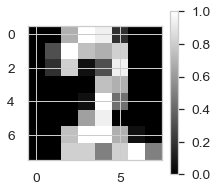

In [30]:
plt.imshow(x_tr_NF[0].reshape((8,8)), interpolation='nearest', vmin=0, vmax=1, cmap='gray')
plt.colorbar();
plt.gcf().set_size_inches((3,3));

## Show fifth row image in training set

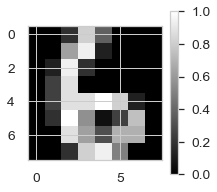

In [31]:
plt.imshow(x_tr_NF[4].reshape((8,8)), interpolation='nearest', vmin=0, vmax=1, cmap='gray')
plt.colorbar();
plt.gcf().set_size_inches((3,3));

# Fit PCA with 10 components to this image dataset

We'll fit this to the entire training set.

In [32]:
K = 10

In [33]:
digit_pca = sklearn.decomposition.PCA(n_components=K)

In [34]:
digit_pca.fit(x_tr_NF)

PCA(n_components=10)

Unpack the mean parameter

In [35]:
m_F = digit_pca.mean_

Unpack the weights (K x F matrix)

In [36]:
w_KF = digit_pca.components_

In [37]:
w_KF.shape

(10, 64)

## Show the mean image

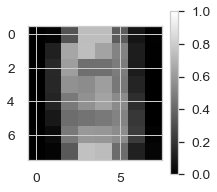

In [38]:
plt.imshow(m_F.reshape((8,8)), interpolation='nearest', vmin=0, vmax=1, cmap='gray')
plt.colorbar();
plt.gcf().set_size_inches((3,3));

## Show the weight vectors for the first 10 components (each one reshaped as an image)

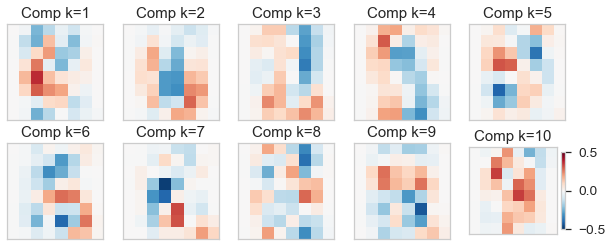

In [39]:
W = 2
H = 2
fig, axgrid = plt.subplots(nrows=2, ncols=5, figsize=(5*W, 2*H))
for k in range(10):
    cur_ax = axgrid.flatten()[k]
    im_handle = cur_ax.imshow(w_KF[k].reshape((8,8)), interpolation='nearest', vmin=-.5, vmax=.5, cmap='RdBu_r')
    cur_ax.set_xticks([]);
    cur_ax.set_yticks([]);
    cur_ax.set_title("Comp k=%d" % (k+1))
    if k == K - 1:
        plt.colorbar(im_handle, fraction=0.04, shrink=1.0);

## Discussion 2a: Are these interpretable? Do you see evidence of the "digits" here?

Look for evidence of strong vertical lines, or certain holes, etc. What are these components capturing?

In [40]:
# TODO discuss

## Create reconstructed images

In [41]:
x_tr_NF.shape

(1697, 64)

In [42]:
z_tr_NK = my_transform(x_tr_NF, w_KF, m_F)

In [43]:
z_tr_NK.shape

(1697, 10)

In [44]:
xhat_tr_NF = np.dot(z_tr_NK, w_KF) + m_F[np.newaxis,:]

In [45]:
xhat_tr_NF.shape

(1697, 64)

## Show the original and reconstructed images from training set

We'll look at *first five* training examples.

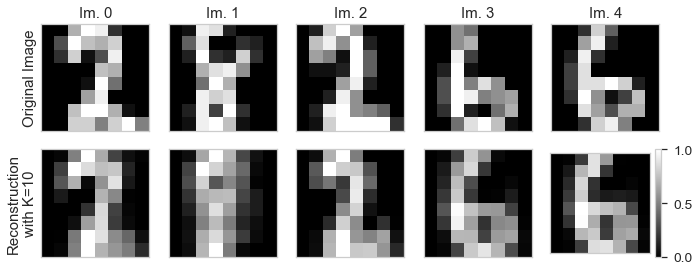

In [46]:
row_ids = [0, 1, 2, 3, 4]

W = 2
H = 2
fig, axgrid = plt.subplots(nrows=2, ncols=len(row_ids), figsize=(5*W, 2*H))

# Top row: original images (rows of x_tr_NF)
for col_id, row_id in enumerate(row_ids):
    cur_ax = axgrid.flatten()[col_id]
    im_handle = cur_ax.imshow(x_tr_NF[row_id].reshape((8,8)),
                              interpolation='nearest', vmin=0.0, vmax=1.0, cmap='gray')
    if col_id == 0:
        cur_ax.set_ylabel("Original Image")
    cur_ax.set_title("Im. %d" % (row_id))
    cur_ax.set_xticks([]);
    cur_ax.set_yticks([]);



# Bottom row: reconstructed images (rows of xhat_tr_NF)

for col_id, row_id in enumerate(row_ids):
    cur_ax = axgrid[1].flatten()[col_id]
    im_handle = cur_ax.imshow(xhat_tr_NF[row_id].reshape((8,8)),
                              interpolation='nearest', vmin=0.0, vmax=1.0, cmap='gray')
    if col_id == 0:
        cur_ax.set_ylabel("Reconstruction\nwith K=10")
    cur_ax.set_xticks([]);
    cur_ax.set_yticks([]);
plt.colorbar(im_handle, fraction=0.05);
plt.tight_layout()



## Show more original and reconstructed images from training set: All 9s

We'll look at *five other* training examples, selected because they are all 9s

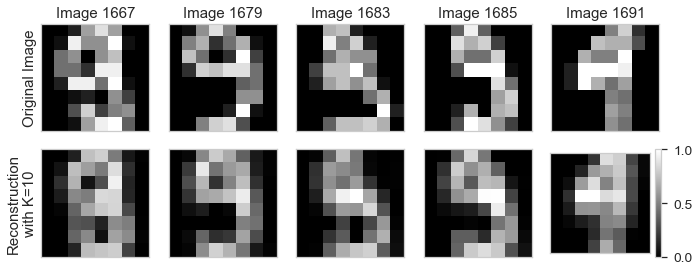

In [47]:
row_ids = np.hstack(np.flatnonzero(y_tr_N== 9)[-5:])
W = 2
H = 2
fig, axgrid = plt.subplots(nrows=2, ncols=len(row_ids), figsize=(5*W, 2*H))

# Top row: original images (rows of x_tr_NF)
for col_id, row_id in enumerate(row_ids):
    cur_ax = axgrid.flatten()[col_id]
    if col_id == 0:
        cur_ax.set_ylabel("Original Image")
    cur_ax.set_title("Image %d" % (row_id))
    im_handle = cur_ax.imshow(x_tr_NF[row_id].reshape((8,8)),
                              interpolation='nearest', vmin=0.0, vmax=1.0, cmap='gray')
    cur_ax.set_xticks([]);
    cur_ax.set_yticks([]);



# Bottom row: reconstructed images (rows of xhat_tr_NF)

for col_id, row_id in enumerate(row_ids):
    cur_ax = axgrid[1].flatten()[col_id]
    if col_id == 0:
        cur_ax.set_ylabel("Reconstruction\nwith K=10")
    im_handle = cur_ax.imshow(xhat_tr_NF[row_id].reshape((8,8)),
                              interpolation='nearest', vmin=0.0, vmax=1.0, cmap='gray')
    cur_ax.set_xticks([]);
    cur_ax.set_yticks([]);
plt.colorbar(im_handle, fraction=0.05);
plt.tight_layout()



## Discussion 2b: How good are these reconstructions?

Across the two plots above, what do you notice?

Remember that we are storing only 10 values for each image, not 64, which is a 6x savings!

Given that, do you think the reconstructions are pretty good? What visual aspects aren't covered very well?

## Exercise 2c: Show reconstructions for the first five *test* examples


Step 1: Compute the low-dimensional embedding for the test set x_te_TF

In [48]:
z_te_TK = None # TODO transform x_te_TF to obtain z_te_TK by calling pca.transform

In [49]:
xhat_te_TF = np.zeros((T,F)) # TODO reconstruct the data by multiplying weights times z, plus adding the mean

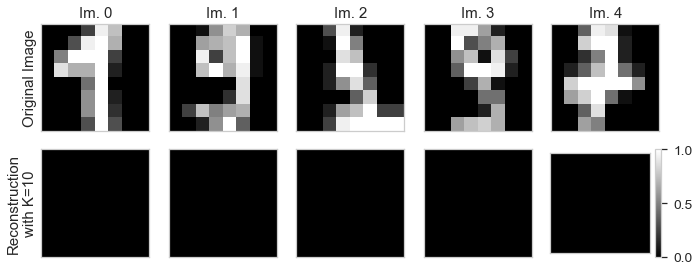

In [50]:
row_ids = [0, 1, 2, 3, 4] # row ids for our test set
W = 2
H = 2
fig, axgrid = plt.subplots(nrows=2, ncols=len(row_ids), figsize=(5*W, 2*H))

# Top row: original images (rows of x_tr_NF)
for col_id, row_id in enumerate(row_ids):
    cur_ax = axgrid.flatten()[col_id]
    if col_id == 0:
        cur_ax.set_ylabel("Original Image")
    cur_ax.set_title("Im. %d" % (row_id))
    im_handle = cur_ax.imshow(x_te_TF[row_id].reshape((8,8)),
                              interpolation='nearest', vmin=0.0, vmax=1.0, cmap='gray')
    cur_ax.set_xticks([]);
    cur_ax.set_yticks([]);



# Bottom row: reconstructed images (rows of xhat_tr_NF)
for col_id, row_id in enumerate(row_ids):
    cur_ax = axgrid[1].flatten()[col_id]
    if col_id == 0:
        cur_ax.set_ylabel("Reconstruction\nwith K=10")
    im_handle = cur_ax.imshow(xhat_te_TF[row_id].reshape((8,8)),
                              interpolation='nearest', vmin=0.0, vmax=1.0, cmap='gray')
    cur_ax.set_xticks([]);
    cur_ax.set_yticks([]);
plt.colorbar(im_handle, fraction=0.05);
plt.tight_layout()



## Discussion 2d: Is the PCA model good at reconstructing the test examples it has never seen before?

Why or why not? Do you notice any differences compared to the training data?

# Part 3: PCA with ALL components and selecting K

## First, fit PCA that learns all possible components

Remember that in general, PCA is a *nested* model.

The weights for K=5 are just the first 5 rows of the weights for K=6.

The weights for K=9 are just the first 9 rows of the weights for K=10 or K=15, etc.

In [51]:
all_pca = sklearn.decomposition.PCA().fit(x_tr_NF)

# Determine how each additional component explains observed variance better

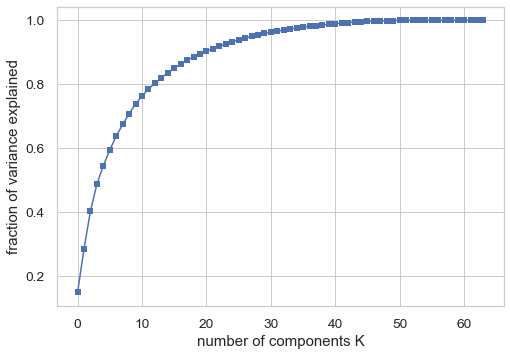

In [52]:
plt.plot(np.cumsum(all_pca.explained_variance_ratio_), 'bs-');
plt.xlabel('number of components K');
plt.ylabel('fraction of variance explained');

## Exercise 3a: What K value will give you at least 80% of the variance? 95%?

Specify a concrete K value, by carefully interpreting the plot above.

Often, we use these heuristics to choose a K that strikes a balance between "good" reconstruction and small size.

## Exercise 3b: Visualize reconstructions for the first 5 training set images with K=30.


In [53]:
# TODO compute z

In [54]:
# TODO compute xhat given z

In [55]:
# TODO make plot of reconstructions xhat

## Exercise 3c: Visualize reconstructions for the first 5 *test* set images with K=30.


In [56]:
# TODO compute z

In [57]:
# TODO compute xhat given z

In [58]:
# TODO make plot of reconstructions xhat

# Part 4: Understanding what we mean by "explained variance"

A goal of PCA is to find a low-dimensional reconstruction of our data that contains all the possible "information" of our original data.

One way to define this precisely is to first look at squared error "reconstruction cost" of using just the empirical mean of our training data (this is like PCA with $K=0$)

\begin{align}
\text{cost}_{K=0}(X, m) &= \frac{1}{N} \sum_{n=1}^N \sum_{f=1}^F (x_{nf} - m_f)^2 \\
&= \frac{1}{N} \sum_{n=1}^N \sum_{f=1}^F \tilde{x}_{nf}^2, \qquad \tilde{x}_{nf} = x_{nf} - m_f
\end{align}

Note that this cost is precisely equal to the *empirical variance* of the training set, since variance is the average squared error from the mean.

This is just a property of the data itself. We can't change it. But it gives us a place to start when quantifying the quality of a reconstruction.

Now, consider a reconstruction that uses the mean $m$ as well as a good $K$-dimensional weight component matrix $W$.

We should be able to do better than the baseline above, right?

Let's write the cost when we have $K>0$ principal components:

\begin{align}
\text{cost}_K(X, m, W) &= \frac{1}{N}  \sum_{n=1}^N \sum_{f=1}^F (x_{nf} - m_f - \sum_{k=1}^K W_{kf} \tilde{x}_{nf} )^2 \\
\\
&= \frac{1}{N}  \sum_{n=1}^N \sum_{f=1}^F (\tilde{x}_{nf} - \sum_{k=1}^K W_{kf} \tilde{x}_{nf} )^2 \\
\end{align}

Now, this cost will have units that depend on the scale of the original data. However, we can look at the *ratio* of this cost to the original mean-only cost above.

\begin{align}
\text{frac-unexplained-variance} = \frac{\text{cost}_K(X, m, W)}{\text{cost}_{K=0}(X,m)}
    &= \frac
        { \frac{1}{N}  \sum_{n=1}^N \sum_{f=1}^F (\tilde{x}_{nf} - \sum_{k=1}^K W_{kf} \tilde{x}_{nf} )^2 }
        { \frac{1}{N}  \sum_{n=1}^N \sum_{f=1}^F \tilde{x}_{nf}^2 }
\end{align}

Notice that as $K \rightarrow 0$, this ratio approaches 1, while as $K \rightarrow F$ this ratio approaches 0 on the training set. It turns out that this ratio will *monotonically decrease* as we increase $K$ and iteratively find the optimal weights $W$ for that K value. 

We can thus interpret this fraction as a measure of the *unexplained* variance of our original dataset. If the fraction is close to 1., most of our data is not well approximated by our PCA reconstructions. If the fraction is close to 0, we are doing a good job (most of the variance is accounted for).



### Surprising result: We can compute this fraction simply using sums of eigenvalues we already have!

Now we can show a surprising result. The denominator can be computed as the sum of all eigenvalues of the covariance of $X$. And the numerator can be computed as a partial version of this sum.

$$
\text{frac-unexplained-variance} = \frac{\text{cost}_K(X, m, W)}{\text{cost}_{K=0}(X,m)}
    = \frac
        { \sum_{\ell={K+1}}^F \lambda_{\ell} }
        { \sum_{f={1}}^F \lambda_{f} }
$$

where $\lambda_k$ is the $k$-th largest eigenvalue of the $F \times F$ covariance matrix of the training data

## Computing the denominator (PCA with K=0 reconstruction cost) in 3 ways

### Method 1: Directly compute reconstruction cost with K=0 model

In [59]:
m_1F = np.mean(x_tr_NF, axis=0)[np.newaxis,:]

In [60]:
costK0_v1 = np.sum(np.mean(np.square(x_tr_NF - m_1F), axis=0))

In [61]:
costK0_v1

4.686065871686287

### Method 2: Compute cost by measuring empirical variance of each feature and adding up

In [62]:
cov_FF = np.cov(x_tr_NF.T, bias=1)

In [63]:
var_F = np.diag(cov_FF)

In [64]:
costK0_v2 = np.sum(var_F)

In [65]:
costK0_v2

4.6860658716862815

### Method 3: Compute cost as sum of eigenvalues of covariance matrix

In [66]:
lam_F, W_FF = np.linalg.eig(cov_FF)

Get eigenvalues in sorted order from big to small

In [67]:
sorted_ids = np.argsort(-1 * lam_F)

In [68]:
lam_F = lam_F[sorted_ids]
W_FF = W_FF[:, sorted_ids]

In [69]:
lam_F[:10]

array([0.69601696, 0.64133098, 0.55282934, 0.39584765, 0.26867765,
       0.2312219 , 0.20297662, 0.17096015, 0.15846922, 0.14244372])

In [70]:
costK0_v3 = np.sum(lam_F)

In [71]:
costK0_v3

4.686065871686285

Verify all three methods are the same!

In [72]:
costK0_v1

4.686065871686287

In [73]:
costK0_v2

4.6860658716862815

In [74]:
costK0_v3

4.686065871686285

## Computing the numerator (PCA with K-components reconstruction cost) in 2 ways

In [75]:
K = 3

In [76]:
xtilde_NF = x_tr_NF - m_1F

### Method 1: Direct reconstruction cost calculation

In [77]:
W_KF = W_FF[:, :K].T.copy()

Compute xhat given x in 2 steps:

* project each x to z
* then project each z back to xhat

In [78]:
# Step 1: x to z
z_tr_NK = np.dot(xtilde_NF, W_KF.T)

In [79]:
# Step 2: z to xhat
xhat_tr_NF = np.dot(z_tr_NK, W_KF) + m_1F

Now compute the total reconstruction cost

In [80]:
costK_v1 = np.sum(np.mean(np.square(x_tr_NF - xhat_tr_NF), axis=0))

In [81]:
costK_v1

2.7958885969409755

### Method 2: Calculation just summing all eigenvalues except the top-K

In [82]:
costK_v2 = np.sum(lam_F[K:])

In [83]:
costK_v2

2.795888596940978

In [84]:
np.allclose(costK_v1, costK_v2)

True

## Bringing it all together: Fraction of variance explained

Thus, a measure of our reconstruction quality on the training set is given by the fraction of variance that is explained by our $K$-component PCA

Note, we switch here to using fraction-of-explained-variance (rather than unexplained).

$$
\text{frac-explained-variance} = 1 - \frac{\text{cost}_K(X, m, W)}{\text{cost}_{K=0}(X,m)}
    = \frac
        { \sum_{\ell={1}}^K \lambda_{\ell} }
        { \sum_{f={1}}^F \lambda_{f} }
$$


In [85]:
K

3

### Version 1: Ratio of direct reconstruction costs (PCA with K to PCA with 0 components)

In [86]:
frac_explained_var = 1 - (costK_v1 / costK0_v1)

In [87]:
frac_explained_var

0.4033612259200122

### Version 2: Ratio of sums of eigenvectors

In [88]:
frac_explained_var_v2 = np.sum(lam_F[:K]) / np.sum(lam_F)

In [89]:
frac_explained_var_v2

0.40336122592001156

### Version 3: Check against sklearn implementation

In [90]:
np.sum(all_pca.explained_variance_ratio_[:K])

0.4033612259200119